In [1]:
import json
import pandas as pd
from mlinterpreter.util import preprocess_data
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

/home/caihengxing/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# 读入数据 和 schema
data_path = "./demo_data/adult.data"
schema_path = "./demo_data/schema.json"
df = pd.read_csv(data_path, header=None)
df.columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex",
                 "capital-gain","capital-loss","hours-per-week","native-country","income"]
with open(schema_path, "r") as f:
    schema = json.load(f)

In [3]:
for col in schema['features']:
    if col['type'] == 'Numeric':
        df[col['name']] = pd.to_numeric(df[col['name']]).fillna(0)
    elif col['type'] == 'Category':
        df[col['name']] = df[col['name']].astype(str)

In [4]:
# 编码label
le = preprocessing.LabelEncoder()
y = le.fit_transform(df[schema['label']])
le.classes_

array([' <=50K', ' >50K'], dtype=object)

In [5]:
ct = ColumnTransformer(
    [[col['name'], preprocessing.StandardScaler(), [col['name']]] for col in  schema['features'] if col['type'] =='Numeric' and col['name'] != schema['label']] +
    [[col['name'], OneHotEncoder(handle_unknown='ignore'), [col['name']]] for col in schema['features'] if col['type'] =='Category' and col['name'] != schema['label']]
    )
train_x = ct.fit_transform(df)
columns = []
for ins in ct.transformers_:
    if isinstance(ins[1], preprocessing.StandardScaler):
        columns.append(ins[0])
    elif isinstance(ins[1], OneHotEncoder):
        columns += ["{}.{}".format(ins[0], i) for i in ins[1].categories_[0]]

/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated 

In [6]:
from sklearn.linear_model import LinearRegression

/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

In [7]:
lr = LinearRegression()
lr.fit(train_x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
lr_imp = pd.DataFrame(columns)
lr_imp.columns = ['column']
lr_imp['importance'] = lr.coef_
lr_imp['importance_abs'] = abs(lr.coef_)
lr_imp = lr_imp.sort_values(by = 'importance_abs', ascending = False)

In [9]:
lr_imp

,column,importance,importance_abs
58,relationship. Wife,0.190654,0.190654
67,native-country. Cambodia,0.167092,0.167092
81,native-country. Holand-Netherlands,-0.143475,0.143475
14,workclass. Without-pay,-0.134732,0.134732
94,native-country. Outlying-US(Guam-USVI-etc),-0.132514,0.132514
...,...,...,...
39,occupation. Adm-clerical,0.002638,0.002638
73,native-country. Ecuador,-0.002461,0.002461
38,occupation. ?,0.002039,0.002039
100,native-country. Scotland,-0.001939,0.001939


In [10]:
import matplotlib.pyplot as plt

<BarContainer object of 108 artists>

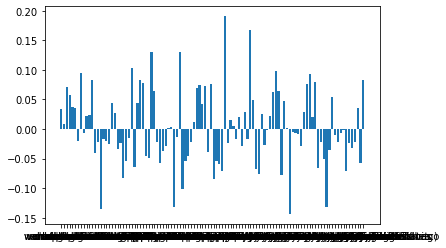

In [11]:
plt.bar(columns, lr.coef_)